# Comment Analysis
## Finding potential Clusters



In [ ]:
import pandas as pd
import io

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving comments_only.csv to comments_only (1).csv


In [ ]:
data = pd.read_csv('comments_only.csv')

In [ ]:
data.head()

,comment_user,comment_time,reply_count,post_comment_count,Channel,comment,title,comment_id,language
0,@JConlon96,2024-11-07 09:54:00,0.0,486,Harris,harris,Big Things | Harris-Walz 2024,25828.0,en
1,@BookMama72,2024-11-07 14:54:00,11.0,480,Harris,im nauseously optimistic this morning lets do ...,Girl Dad | Harris-Walz 2024,41128.0,en
2,@ColeFNCS,2024-11-07 21:54:00,1.0,480,Harris,just voted ballot red lets go america trump i...,Girl Dad | Harris-Walz 2024,46144.0,en
3,@bryanpotter3882,2024-11-07 20:54:00,0.0,413,Harris,kamala harris for president,Good Sense | Harris-Walz 2024,46926.0,no
4,@rhogenelabata2774,2024-11-07 16:54:00,0.0,413,Harris,kentuckian republican here for harriswalz,Good Sense | Harris-Walz 2024,48831.0,en


In [ ]:
comments = data[data['language'] == 'en']['comment'].dropna()

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(comments)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(comments)

In [ ]:
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Apply K-Means clustering
n_clusters = 5  # You can adjust this based on the number of themes you expect
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Add cluster labels to the DataFrame
data.loc[comments.index, 'cluster'] = clusters

Visualization

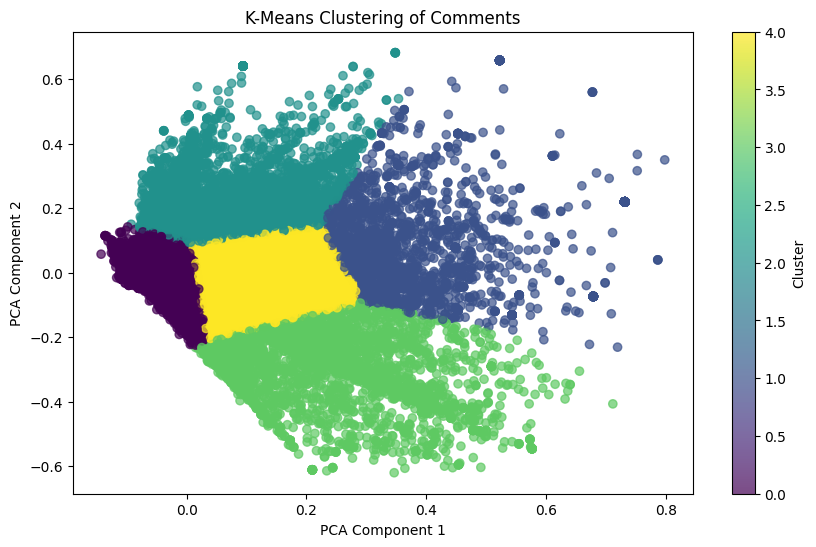

In [ ]:
# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('K-Means Clustering of Comments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
# Print representative comments from each cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(data[data['cluster'] == cluster]['comment'].sample(5, random_state=42).values)



Cluster 0:
[' are they living in another dimension'
 'absolute facts  upfront in your face truth spoken and seen amendment  is your right vote'
 'dear white house    tot'
 'did he lose the  election\n tim im focused on the future\nthat is a hecking nonanswer'
 'congratulations great choice ']

Cluster 1:
['trump is great ' 'i need trump back' 'texans for trump'
 'trump  dont care voting trump voting trump voting trump pastpresent and future republic of america we the people'
 'keep president trump in your prayers']

Cluster 2:
[' marc anthony i definitely remember vote blue '
 'vote blue  \nthrough and\nthrough '
 'the only things standing against my vote to kamala is gary gensler being a part of your administration and your reluctance to give your opinion on the subject of crypto currency no crypto no vote gary gensler no vote'
 'this is so great this was exactly what i need to vote is a fortnite map thank you kamala'
 'vote trump for zero new wars']

Cluster 3:
['i already voted ear

hm okay this categories are not soo useful

## using sentiment analysis

In [ ]:
!pip install nltk transformers pandas scikit-learn matplotlib umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline, AutoTokenizer

In [ ]:
model_name = "distilbert-base-uncased"  # Replace with your sentiment model
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, tokenizer=tokenizer)

# Function to truncate text properly
def truncate_comment(comment, max_length=512):
    tokens = tokenizer.encode(comment, truncation=True, max_length=max_length)
    return tokenizer.decode(tokens, skip_special_tokens=True)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
filtered_comments = comments[comments.apply(lambda x: len(tokenizer.tokenize(x)) <= 512)]

# Update the original dataset to only include filtered comments
data = data.loc[filtered_comments.index]

In [ ]:
from transformers import pipeline

# Ensure truncation is enabled in the pipeline
model_name = "distilbert-base-uncased"  # Replace with your model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model_name,
    tokenizer=model_name,
    truncation=True,
    max_length=512  # Ensure sequences are truncated to the model's max length
)

# Perform sentiment analysis
sentiment_results = sentiment_pipeline(filtered_comments.to_list(), batch_size=16)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
sentiment_labels = [result['label'] for result in sentiment_results]
sentiment_scores = [result['score'] for result in sentiment_results]

prepare feature matrix for the clustering

In [ ]:
# Create a DataFrame for clustering
clustering_data = pd.DataFrame({
    'comment': filtered_comments,
    'sentiment_label': sentiment_labels,
    'sentiment_score': sentiment_scores
})

# One-hot encode sentiment labels for clustering
sentiment_dummies = pd.get_dummies(clustering_data['sentiment_label'])
feature_matrix = pd.concat([sentiment_dummies, clustering_data['sentiment_score']], axis=1)

Clusering with K-means

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(feature_matrix)

# Apply K-Means clustering
n_clusters = 3  # Adjust based on expected emotional categories
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Add cluster labels to the DataFrame
clustering_data['emotion_cluster'] = clusters


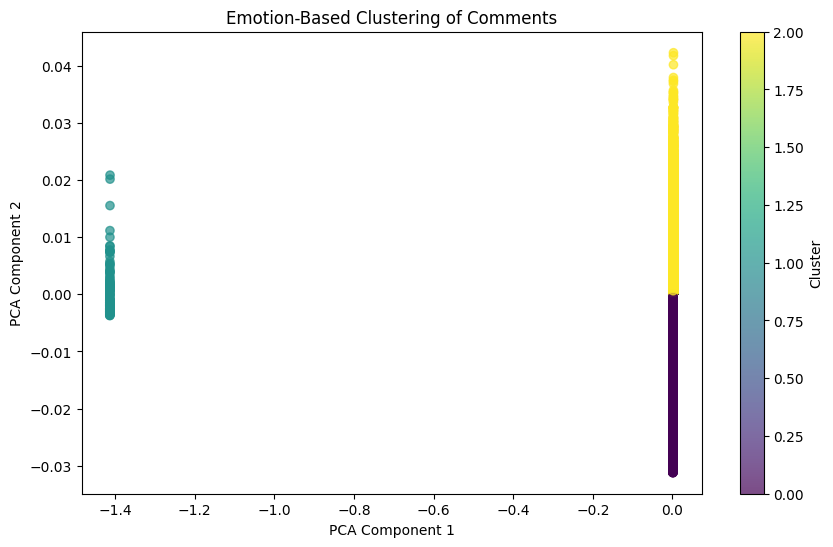

In [ ]:
# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('Emotion-Based Clustering of Comments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
# Print representative comments from each emotion cluster
for cluster in range(n_clusters):
    print(f"\nEmotion Cluster {cluster}:")
    print(clustering_data[clustering_data['emotion_cluster'] == cluster]['comment'].sample(5, random_state=42).values)



Emotion Cluster 0:
['we lovepresident trump   '
 'thank you past and future greatest president ever  donald j trump '
 'thank you for speaking out  up for democracy  harriswalz '
 'amen philippians   corinthians  in your life and the people that role with you president donald j trump'
 'look at that likedislike ratio i see  people calling this truth while only  call it a lie i think ive seen enough to know who im voting for']

Emotion Cluster 1:
['glory to god beatiful love this song nice music god bless yuo brothers  estandos unidos '
 'coesto election ovar rischio democracy per che all american nationality unity coesto discorso'
 'how did kamala obama biden and bernie become millionaires  by working for the government'
 ' sgt johanny rosario pichardo  of lawrence massachusetts\n sgt nicole l gee  of sacramento california\n staff sgt darin t hoover  of salt lake city utah\n cpl hunter lopez  of indio california\n cpl daegan w page  of omaha nebraska\n cpl humberto a sanchez  of logan

In [ ]:
sentiment_data = pd.DataFrame({
    'comment': filtered_comments,
    'sentiment_label': sentiment_labels,
    'sentiment_score': sentiment_scores
})

In [ ]:
sentiment_data.head()

,comment,sentiment_label,sentiment_score
0,harris,LABEL_0,0.539228
1,im nauseously optimistic this morning lets do ...,LABEL_0,0.521866
2,just voted ballot red lets go america trump i...,LABEL_0,0.533416
4,kentuckian republican here for harriswalz,LABEL_0,0.540393
6,thank you hadley for continuing to tell your s...,LABEL_0,0.519169


In [ ]:
# Count comments per sentiment category
category_counts = sentiment_data['sentiment_label'].value_counts()
print(category_counts)

sentiment_label
LABEL_0    88206
LABEL_1      106
Name: count, dtype: int64


In [ ]:
# Count comments per sentiment category
category_counts = sentiment_data['sentiment_label'].value_counts()
print(category_counts)

sentiment_label
LABEL_0    88206
LABEL_1      106
Name: count, dtype: int64


In [ ]:
# Display representative comments for each sentiment
for label in sentiment_data['sentiment_label'].unique():
    print(f"\nSentiment: {label}")
    print(sentiment_data[sentiment_data['sentiment_label'] == label].sample(5, random_state=42)['comment'].values)



Sentiment: LABEL_0
['donald trump is my handsome president'
 'their thoughts and opinions are pure gold thank you all'
 'my whole family voted for trump lets make it too big to rig'
 'the experts say that harris has an economic plan that will work for middle class america\n'
 'its like she just learned the word elusive']

Sentiment: LABEL_1
['glory to god beatiful love this song nice music god bless yuo brothers  estandos unidos '
 'coesto election ovar rischio democracy per che all american nationality unity coesto discorso'
 'how did kamala obama biden and bernie become millionaires  by working for the government'
 ' sgt johanny rosario pichardo  of lawrence massachusetts\n sgt nicole l gee  of sacramento california\n staff sgt darin t hoover  of salt lake city utah\n cpl hunter lopez  of indio california\n cpl daegan w page  of omaha nebraska\n cpl humberto a sanchez  of logansport indiana\n lance cpl david l espinoza  of rio bravo texas\n lance cpl jared m schmitz  of st charles m

as this is more positive/negative - I now want to classify emotions:

In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    print("No GPU available")


GPU is available: Tesla T4


In [ ]:
from transformers import pipeline

# Load the emotion classification model with truncation and padding
emotion_pipeline = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    tokenizer="j-hartmann/emotion-english-distilroberta-base",
    device=0,  # Use GPU
    truncation=True,  # Truncate sequences to max_length
    padding=True,  # Pad sequences to uniform length in each batch
    max_length=512  # Explicitly set the max sequence length
)

# Perform emotion analysis with batch processing
emotion_results = emotion_pipeline(comments.to_list(), batch_size=16)


In [ ]:
# Extract labels and scores
emotion_labels = [result['label'] for result in emotion_results]
emotion_scores = [result['score'] for result in emotion_results]

# Create a DataFrame for analysis
emotion_data = pd.DataFrame({
    'comment': comments,
    'emotion_label': emotion_labels,
    'emotion_score': emotion_scores
})

# Display the first few rows
print(emotion_data.head())


                                             comment emotion_label  \
0                                           harris            fear   
1  im nauseously optimistic this morning lets do ...           joy   
2  just voted ballot red lets go america  trump i...       sadness   
4          kentuckian republican here for harriswalz       neutral   
6  thank you hadley for continuing to tell your s...           joy   

   emotion_score  
0       0.571792  
1       0.546489  
2       0.403274  
4       0.924144  
6       0.542303  


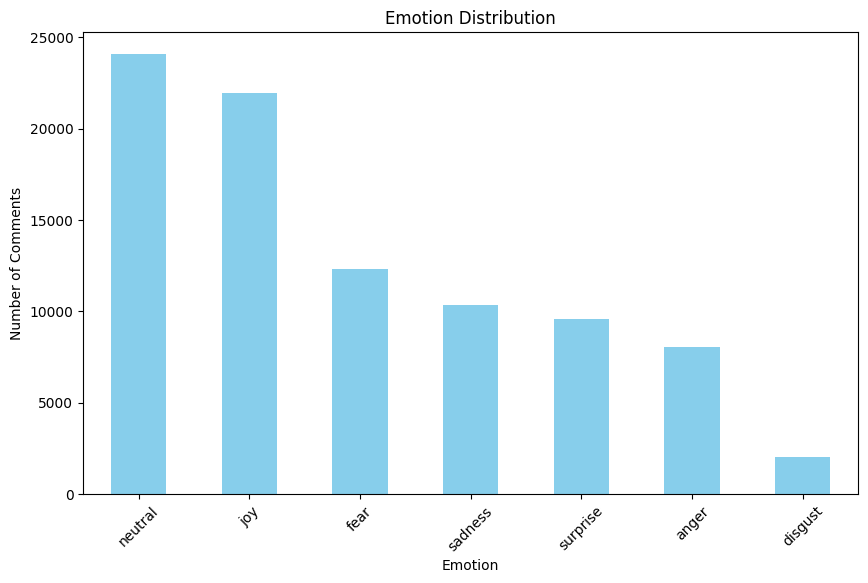

In [ ]:
# Count occurrences of each emotion
emotion_counts = emotion_data['emotion_label'].value_counts()

# Plot the distribution of emotions
import matplotlib.pyplot as plt

emotion_counts.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Group comments by emotion and display examples
for emotion in emotion_data['emotion_label'].unique():
    print(f"\nEmotion: {emotion}")
    examples = emotion_data[emotion_data['emotion_label'] == emotion]['comment'].sample(5, random_state=42).values
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example}")



Emotion: fear
1. what more do you need to know before you vote for bringing the world back from disaster
2. start with education you create wealth by getting education public education is essential look at the people who advanced themselves by advancing their education follow these examples vance sowell jordan of ohio johnson of louisiana kennedy of louisiana massie of kentucky abe lincoln all attended public schools get and value an education as robespierre commented  that education creates freedom whereas ignorance creates tyranny
3. what a fear mongering bs commercial
4. americas only choice vote for the best man to get it done  he didnt disappoint us the last time 
5. well saidlove you president trump 

Emotion: joy
1. noer minghiner italian conservative he likud party israel government he adviser to israel prime minister for israel italy republic  neutral england london britain  downing street support israel government idf related problems issues in middle east politically reflec

## Merging and saving the emotions

In [ ]:
data = data[data['language'] == 'en'].dropna()

In [ ]:
# Ensure filtered_comments has the same index as the original dataset
indices = comments.index

# Create a DataFrame for emotions with the same indices
emotion_results_df = pd.DataFrame({
    'emotion_label': emotion_labels,
    'emotion_score': emotion_scores
}, index=indices)

# Add emotions back to the original dataset
data = data.merge(emotion_results_df, left_index=True, right_index=True, how='left')


In [ ]:
data.head()

,comment_user,comment_time,reply_count,post_comment_count,Channel,comment,title,comment_id,language,cluster,emotion_label_x,emotion_score_x,emotion_label_y,emotion_score_y
0,@JConlon96,2024-11-07 09:54:00,0.0,486,Harris,harris,Big Things | Harris-Walz 2024,25828.0,en,0.0,fear,0.571792,fear,0.571792
1,@BookMama72,2024-11-07 14:54:00,11.0,480,Harris,im nauseously optimistic this morning lets do ...,Girl Dad | Harris-Walz 2024,41128.0,en,0.0,joy,0.546489,joy,0.546489
2,@ColeFNCS,2024-11-07 21:54:00,1.0,480,Harris,just voted ballot red lets go america trump i...,Girl Dad | Harris-Walz 2024,46144.0,en,4.0,sadness,0.403274,sadness,0.403274
4,@rhogenelabata2774,2024-11-07 16:54:00,0.0,413,Harris,kentuckian republican here for harriswalz,Good Sense | Harris-Walz 2024,48831.0,en,0.0,neutral,0.924144,neutral,0.924144
6,@mamabeargardens9439,2024-11-07 15:54:00,3.0,753,Harris,thank you hadley for continuing to tell your s...,"64,000 :60 | Harris-Walz 2024",75511.0,en,0.0,joy,0.542303,joy,0.542303


In [ ]:
# Save the updated dataset to a CSV file
data.to_csv("comments_english_with_emotions.csv", index=False)

In [ ]:
from google.colab import files

# Download the saved CSV file
files.download("comments_english_with_emotions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>